# TPG Examples
This document shows how to use the PyTPG API. We make use of OpenAI Gym to run examples, and we assume you already have PyTPG installed, see the readme for installation instructions for PyTPG.

## General Setup

In [1]:
from __future__ import division
# imports to run OpenAI Gym in Jupyter
import gym
import matplotlib.pyplot as plt
from IPython import display

# how to render in Jupyter: 
# https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
# https://www.youtube.com/watch?v=O84KgRt6AJI
def show_state(env, step=0, name='', info=''):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (name, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
# transforms the state into what the tpg agent can use.
# From 3D to 1D, taking only red data (from rgb array)
def getState(state):
    state2 = []
    for x in state:
        for y in x:
            state2.append(y[0])
            
    return state2

In [2]:
env = gym.make('Assault-v0') # make the environment

In [3]:
print(env.action_space) # learn size of action space

Discrete(7)


In [4]:
# import to do training
from tpg.tpg_trainer import TpgTrainer
# import to run an agent (always needed)
from tpg.tpg_agent import TpgAgent

## Generational Selection

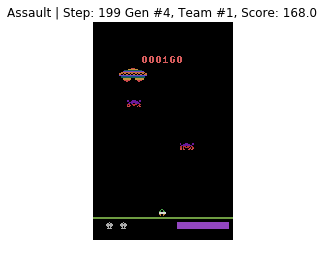

Time Taken (Seconds): 8171.82666182518
Results:
Min, Max, Avg
0.0 168.0 20.58
0.0 189.0 38.65909090909091
0.0 168.0 56.34146341463415
0.0 189.0 72.06818181818181
0.0 189.0 106.10526315789474


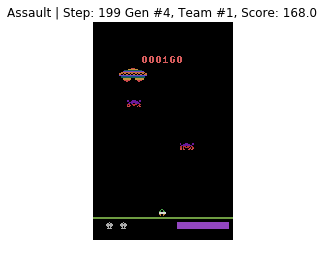

In [5]:
%matplotlib inline
import time # for tracking time

tStart = time.time()

# first create an instance of the TpgTrainer
# this creates the whole population and everything
trainer = TpgTrainer(actions=range(7), teamPopSizeInit=50)

curScores = [] # hold scores in a generation
summaryScores = [] # record score summaries for each gen (min, max, avg)

# 5 generations isn't much (not even close), but some improvements
# should be seen.
for gen in range(5): # generation loop
    curScores.clear() # new list per gen
    
    while True: # loop to go through agents
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break # no more agents, so proceed to next gen
        
        state = env.reset() # get initial state and prep environment
        score = 0
        for i in range(200): # run episodes that last 200 frames
            show_state(env, i, 'Assault', 'Gen #' + str(gen) + 
                       ', Team #' + str(teamNum) +
                       ', Score: ' + str(score)) # render env
            
            act = agent.act(getState(state)) # get action from agent
            
            # feedback from env
            state, reward, isDone, debug = env.step(act)
            score += reward # accumulate reward in score
            if isDone:
                break # end early if losing state
                
        agent.reward(score) # must reward agent
        curScores.append(score) # store score
            
    # at end of generation, make summary of scores
    summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    trainer.evolve()
    
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results:\nMin, Max, Avg')
for result in summaryScores:
    print(result[0],result[1],result[2])

# Generational Selection with Multiprocessing

In [15]:
import multiprocessing as mp
import time

tStart = time.time()

trainer = TpgTrainer(actions=range(7), teamPopSizeInit=50)

m = mp.Manager()
envQueue = m.Queue()
# each worker needs its own environment
for i in range(workers):
    envQueue.put(gym.make('Assault-v0'))
    
summaryScores = [] # record score summaries for each gen (min, max, avg)

# run agent in function to work with multiprocessing
def runAgent(agent, eq, sq):
    print('Waiting for env...')
    print(eq.qsize())
    env = eq.get() # get an environment
    print('Agent #' + str(agent.getId()) + ' starting.')
    state = env.reset() # get initial state and prep environment
    score = 0
    for i in range(200): # run episodes that last 200 frames
        act = agent.act(getState(state)) # get action from agent

        # feedback from env
        state, reward, isDone, debug = env.step(act)
        score += reward # accumulate reward in score
        if isDone:
            break # end early if losing state

    agent.reward(score) # must reward agent
    sq.put(score) # store score
    
    print('Agent #' + str(agent.getId()) + ' finished with score ' + str(score))
    
    e.put(env) # put environment back
    
    
for gen in range(5): # generation loop
    curScores = m.Queue() # hold scores in a generation (queue so thread safe)
    
    # run generation
    pool = mp.Pool(processes=5)
    pool.starmap(runAgent, 
                 [(agent, envQueue, curScores) 
                  for agent in trainer.getAllAgents()])
            
    # at end of generation, make summary of scores
    scoreRec.append((min(list(curScores)), max(list(curScores)),
                    sum(list(curScores))/len(curScores))) # min, max, avg
    
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results: ' + str(scoreRec))

Waiting for env...
5
Waiting for env...
4
Waiting for env...
3
Waiting for env...
2
Waiting for env...
1
Waiting for env...
0
Waiting for env...
0
Waiting for env...
0
Waiting for env...
0
Waiting for env...
0


Process ForkPoolWorker-139:
Process ForkPoolWorker-135:
Process ForkPoolWorker-137:
Process ForkPoolWorker-136:
Process ForkPoolWorker-138:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/amaral/anaconda2/envs/oaigym/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/amaral/anaconda2/envs/oaigym/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/amaral/anaconda2/envs/oaigym/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/amaral/anaconda2/envs/oaigym/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/amaral/anaconda2/envs/oaigym/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/amaral/anaconda2/envs/oaigym/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/h

## Tournament Selection